In [1]:
import string 
import re
import itertools
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model 
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|]", "", text)
    text = " ".join(text.split())
    return text

In [4]:
with open('/content/movie_lines.txt', 'r', encoding='cp1252') as movie_lines:
    lines = movie_lines.read().split('\n')
    
movie_line_dict = {}
for line in lines:
    text = line.split(' +++$+++ ')[-1]
    index = line.split(' +++$+++ ')[0]
    clean_line = clean_text(text)
    tokinized_text = nltk.word_tokenize(clean_line)
    movie_line_dict[index] = list(' '.join(tokinized_text))
        

with open('/content/movie_conversations.txt', 'r', encoding='cp1252') as movie_conversation:
    lines = movie_conversation.read().split('\n')
movie_conversation_list = [line.split(' +++$+++ ')[-1][1:-1].replace("'", '').split(', ') for line in lines]

FileNotFoundError: ignored

In [5]:
words = list(' '.join(list(itertools.chain(*list(movie_line_dict.values())))))
values, count = np.unique(words, return_counts=True)

letters_df = pd.DataFrame({'letter': values, 'count': count})
letters_df.sort_values('count', ascending = False, inplace=True)
fig, ax = plt.subplots(1, 2, figsize = (20,10))
sns.barplot(data = letters_df.iloc[0:int(letters_df.shape[0]/2)],
            y = 'letter',
            x = 'count',
            orient = 'h',
            ax = ax[0])
sns.barplot(data = letters_df.iloc[int(letters_df.shape[0]/2):],
            y = 'letter',
            x = 'count',
            orient = 'h',
            ax = ax[1])
plt.show()

NameError: ignored

In [ ]:
letters = letters_df.iloc[:int(letters_df.shape[0]/2)+1].letter.values
vocab = {item: i+4 for i, item in enumerate(letters)}
vocab['<START>'] = 0
vocab['<FINISH>'] = 3
vocab['<PAD>'] = 2
vocab['<UNK>'] = 1
inv_vocab = {i: j for j, i in vocab.items()}
VOCAB_SIZE = len(vocab)

In [ ]:
def char2indx(text: np.array, dec_tar=False, dec_inp=False):
    if dec_tar:
        return np.array([vocab[i] if i in vocab.keys() else 1 for i in text] + [3])
    if dec_inp:
        return np.array([0] + [vocab[i] if i in vocab.keys() else 1 for i in text])
    
    return np.array([vocab[i] if i in vocab.keys() else 1 for i in text])

def indx2char(mass: np.array):
    return ''.join([inv_vocab[i] for i in mass])

In [ ]:
encoder_input, decoder_input, decoder_target  = [], [], []

for conv in movie_conversation_list:
    for line in range(len(conv)-1): 
        encoder_input.append(char2indx(movie_line_dict[conv[line]]))
        decoder_input.append(char2indx(movie_line_dict[conv[line+1]], dec_inp= True))
        decoder_target.append(char2indx(movie_line_dict[conv[line+1]], dec_tar= True))

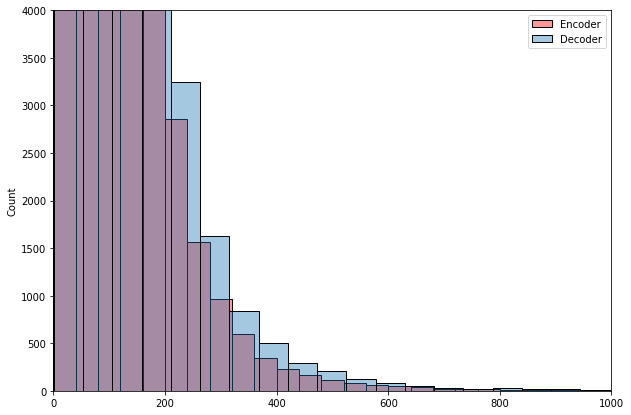

In [ ]:
ax = plt.figure(figsize=(10,7))
plt.xlim(0, 1000)
plt.ylim(0, 4000)

sns.histplot([len(i) for i in encoder_input], bins = 40, color='r', alpha = .4, label = 'Encoder',)
sns.histplot([len(i) for i in decoder_input], bins = 60, alpha =.4, label = 'Decoder')
plt.legend()
plt.show()

In [ ]:
MAX_LEN_SEQ = 200

encoder_input_seqs = pad_sequences(
    encoder_input,
    value=vocab['<PAD>'],
    padding='post',
    truncating='post',
    maxlen=MAX_LEN_SEQ)

decoder_input_seqs = pad_sequences(
    decoder_input,
    value=vocab['<PAD>'],
    padding='post',
    truncating='post',
    maxlen=MAX_LEN_SEQ)

decoder_target_seqs = pad_sequences(
    decoder_target,
    value=vocab['<PAD>'],
    padding='post',
    truncating='post',
    maxlen=MAX_LEN_SEQ)


print('encoder_input_seqs shape: ', encoder_input_seqs.shape)
print('decoder_input_seqs shape: ', decoder_input_seqs.shape)
print('decoder_target_seqs shape: ', decoder_target_seqs.shape)

encoder_input_seqs shape:  (221616, 200)
decoder_input_seqs shape:  (221616, 200)
decoder_target_seqs shape:  (221616, 200)


In [ ]:
print('encoder_input_seqs:\n', indx2char(encoder_input_seqs[10258]), end = '\n==============================\n')
print('decoder_input_seqs:\n', indx2char(decoder_input_seqs[10258]), end = '\n==============================\n')
print('decoder_target_seqs:\n', indx2char(decoder_target_seqs[10258]), end = '\n==============================\n')

encoder_input_seqs:
 no .<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

In [ ]:
len_seq = [sum([True for word in i if word != 2]) > 120 and sum([True for word in i if word != 2]) > 120 < 200 for i in decoder_target_seqs]

encoder_input_seqs_trimmed = []
decoder_input_seqs_trimmed = []
decoder_target_seqs_trimmed = []

for i in range(len(len_seq)):
  if len_seq[i]:
    encoder_input_seqs_trimmed.append(encoder_input_seqs[i]) 
    decoder_input_seqs_trimmed.append(decoder_input_seqs[i])
    decoder_target_seqs_trimmed.append(decoder_target_seqs[i])

encoder_input_seqs_trimmed = np.array(encoder_input_seqs_trimmed)
decoder_input_seqs_trimmed = np.array(decoder_input_seqs_trimmed)
decoder_target_seqs_trimmed = np.array(decoder_target_seqs_trimmed)

In [ ]:
print('encoder_input_seqs:\n', indx2char(encoder_input_seqs_trimmed[100]), end = '\n==============================\n')
print('decoder_input_seqs:\n', indx2char(decoder_input_seqs_trimmed[100]), end = '\n==============================\n')
print('decoder_target_seqs:\n', indx2char(decoder_target_seqs_trimmed[100]), end = '\n==============================\n')

encoder_input_seqs:
 that is true<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
decoder_input_seqs:
 <STAR

In [ ]:
data_enc, _, data_dec_tar, _, data_dec_inp, _ = train_test_split(
    *(encoder_input_seqs_trimmed, decoder_input_seqs_trimmed, decoder_target_seqs_trimmed,
    ),
    train_size = 0.2)

print('data_enc shape: ', data_enc.shape)
print('data_dec_tar shape: ', data_dec_tar.shape)
print('data_dec_inp shape: ', data_dec_inp.shape)

data_enc shape:  (4935, 200)
data_dec_tar shape:  (4935, 200)
data_dec_inp shape:  (4935, 200)


In [ ]:
enc_train, enc_val, dec_tar_train, dec_tar_val, dec_inp_train, dec_inp_val = train_test_split(
    *(data_enc, data_dec_tar,data_dec_inp),
    train_size = 0.9)

print('enx_train shape: ', enc_train.shape)
print('enx_val shape: ', enc_val.shape)
print('dec_tar_train shape: ', dec_tar_train.shape)
print('dec_tar_val shape: ', dec_tar_val.shape)
print('dec_inp_train shape: ', dec_inp_train.shape)
print('dec_inp_val shape: ', dec_inp_val.shape)


enx_train shape:  (4441, 200)
enx_val shape:  (494, 200)
dec_tar_train shape:  (4441, 200)
dec_tar_val shape:  (494, 200)
dec_inp_train shape:  (4441, 200)
dec_inp_train shape:  (4441, 200)


In [ ]:
EMB_SIZE = 256
H_SIZE = 512


class Encoder(Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm = LSTM(H_SIZE, return_sequences = False, return_state = True)

    def call(self, inp):
        out = self.emb(inp)
        _, h, c = self.lstm(out)
        return (h, c)
    
class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm = LSTM(H_SIZE, return_sequences = True, return_state = True)
        self.fc = Dense(VOCAB_SIZE, activation = 'softmax')
        
    def call(self, inp, init_state):
        out = self.emb(inp)
        out, h, c = self.lstm(out, initial_state = init_state)
        out = self.fc(out)
        return out, (h, c)
    

encoder = Encoder()
decoder = Decoder()
        
        
encoder_inputs = Input(shape = (None,) )
decoder_inputs = Input(shape = (None,) )

enc_state = encoder(encoder_inputs)
decoder_outputs, _ = decoder(decoder_inputs, enc_state)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
BATCH_SIZE = 512
EPOCHS = 50

callback = ModelCheckpoint(
    '/content/drive/MyDrive/ChatBot',
    save_weights_only=True,    
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

loss = SparseCategoricalCrossentropy()
model.compile(loss = loss, optimizer = 'adam', metrics = ['accuracy'])

model.fit([enc_train, dec_inp_train],
          dec_tar_train,
          epochs = EPOCHS, 
          validation_data=([[enc_val, dec_inp_val]], dec_tar_val),
          batch_size = BATCH_SIZE, 
          callbacks = [callback])

Epoch 1/50
9/9 [==============================] - 400s 42s/step - loss: 3.7734 - accuracy: 0.2895 - val_loss: 3.3014 - val_accuracy: 0.3084
Epoch 2/50
9/9 [==============================] - 366s 41s/step - loss: 3.0227 - accuracy: 0.3125 - val_loss: 2.6916 - val_accuracy: 0.3230
Epoch 3/50
9/9 [==============================] - 365s 41s/step - loss: 2.5648 - accuracy: 0.3368 - val_loss: 2.4833 - val_accuracy: 0.3359
Epoch 4/50
9/9 [==============================] - 365s 41s/step - loss: 2.4276 - accuracy: 0.3449 - val_loss: 2.4237 - val_accuracy: 0.3412
Epoch 5/50
9/9 [==============================] - 367s 41s/step - loss: 2.3885 - accuracy: 0.3480 - val_loss: 2.3904 - val_accuracy: 0.3431
Epoch 6/50
9/9 [==============================] - 368s 41s/step - loss: 2.3570 - accuracy: 0.3487 - val_loss: 2.3607 - val_accuracy: 0.3457
Epoch 7/50
9/9 [==============================] - 369s 41s/step - loss: 2.3192 - accuracy: 0.3500 - val_loss: 2.3143 - val_accuracy: 0.3466
Epoch 8/50
9/9 [====

In [ ]:
max_dec_seq_length = 200

def seq2seq_inference(input_seq):
    state = encoder(input_seq)

    target_seq = np.array([[vocab['<START>']]])

    decoded_sentence = ''
    while True:
        output_tokens, state = decoder(target_seq, state)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = inv_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        if len(decoded_sentence) > max_dec_seq_length:
            print(sampled_char)
            break

        target_seq = np.array([[sampled_token_index]])

    return decoded_sentence

In [ ]:
input_mess = enc_train[0]
state = encoder(input_seq)

target_seq = np.array([[vocab['<START>']]])

decoded_sentence = ''
while True:
    output_tokens, state = decoder(target_seq, state)

    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = inv_vocab[sampled_token_index]
    # print(np.argmax(output_tokens[0, -1, :]))
    decoded_sentence += sampled_char

    if sampled_char == '<END>' or len(decoded_sentence) > max_dec_seq_length:
        print(sampled_char)
        break

    target_seq = np.array([[sampled_token_index]])



' '

In [ ]:
seq = 111

input_seq = enc_train[seq: (seq + 1)]
decoded_sentence = seq2seq_inference(input_seq)
print('-')
print('Input sentence:', enc_train[seq])
print('Result sentence:', decoded_sentence)
print('Target sentence:', dec_tar_train[seq])

 
-
Input sentence: [18  7 16  4 17  7  4 10  7  6  4 11  8 28  5  4  6  7  4 26 13  7 28  5
  4  8 10 18  6 11  9 10 21  4  6  7  4 11  5 13  4 15  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2]
Result sentence: <START>                                                                                                                                                                                                  
Target sentence: [ 0  9  4  8 20  4 10  7  6  4 26 13  7 28  9 10 21  4  6  7  4 11  5 13
  4 15  4  9  4  8 20  4 12 11  7 19  9 10 21  4 11  5 13  4 